In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc

import scipy.interpolate

In [2]:

from time import time

In [3]:

def error(mv_test, # eV
            kvec,factor = 2.68,T_ini = 1000,H0 = 67.810,crazy = False):
    
    Omega_M = 0.3
    Omega_R = 7e-5
    Omega_lambda = 1 - Omega_M - Omega_R
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                }
    H0 /= (3*1e5) # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    #print(bg.keys())
    z = bg["z"]
    a = 1/(z+1)
    aend = a[-1]
    a0 = a[0]
    mv = mv_test * 1e-6
    # cs front faktoren
    


    # udregner Hubbleparameteren

    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

    # udregnger tau 

    def tau_cal(a,y):
        # Vores "tids"-værdi i denne differentialligning er a
        tau = y[0]
        d_tau = 1 / (a ** 2 * H(a))
        return np.array(d_tau)

    # temperatur

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed
    
    if crazy == False:
        def cs(a,mv,factor):
            return factor * Tv(a) / mv
    else:
        def cs(a,mv,factor):
            return (factor * Tv(a) / mv)**2

    
    # udregn a
    def a_solve(τ,y):
        a = y[0]
        a_dt = a * a * H(a)
        return [a_dt]

    tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


    sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
    tau = sol_tau.y[0]

    sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
    a_tau = sol_a.t
    a = sol_a.y[0]

    a_interp = scipy.interpolate.interp1d(a_tau,a)

    # sammenlignings data fra Class

    error = np.zeros(len(kvec))
    def cdm_func(τ,y):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
        d_theta   =  - nabla2phi -  H(a) * theta * a
        return [d_delta,d_theta]

    for k_ind,k in enumerate(kvec):
        delta_class = pts[k_ind]["delta_cdm"]
        theta_class = pts[k_ind]["theta_cdm"]
        tau_class = pts[k_ind]["tau [Mpc]"]
        delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
        theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
        a_class = pts[k_ind]["a"]
        delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
        theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)
        delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
        theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)
        # T-span1
        t_span = [T_ini,tau[-1]]
        y01 = [delta_init,theta_init]
        sol_cdm = sc.solve_ivp(cdm_func, t_span = t_span, y0 = y01)
        t_cdm = sol_cdm.t
        delta_cdm = sol_cdm.y[0]
        delta_cdm_interp = scipy.interpolate.interp1d(t_cdm,delta_cdm)
        def neu_func(τ,y,k,mv,factor):
            delta = y[0]
            theta = y[1]    
            a = a_interp(τ)
            d_delta   = - theta
            delta_cdm = delta_cdm_interp(τ)
            d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta 
            return [d_delta,d_theta]

        y01_neutrino = [delta_neutrino_init,theta_neutrino_init]
        sol_neu = sc.solve_ivp(neu_func, t_span = t_span, y0 = y01_neutrino,args=(k,mv,factor))
        error[k_ind] = delta_neutrino_class[-1] - sol_neu.y[0][-1]


    return error


In [4]:
t0 = time()
print(error(1,list(np.logspace(-5,1,6))))
t1 = time()
print(t1-t0)

[  82.757637     82.50131693   81.27793508 1153.75114027   76.4528445
 -118.37716618]
6.935502290725708


In [5]:
# def error(mv_test,vec,k_ind,factor = 2.68,T_ini = 1000,H0 = 67.810,crazy = False):


[1e-05, 4.641588833612782e-05, 0.00021544346900318823, 0.001, 0.004641588833612777, 0.021544346900318822, 0.1, 0.46415888336127725, 2.154434690031882, 10.0]
0.05 1e-05
0.05 4.641588833612782e-05
0.05 0.00021544346900318823
0.05 0.001
0.05 0.004641588833612777
0.05 0.021544346900318822
0.05 0.1
0.05 0.46415888336127725
0.05 2.154434690031882
0.05 10.0
1.1555555555555554 1e-05
1.1555555555555554 4.641588833612782e-05
1.1555555555555554 0.00021544346900318823
1.1555555555555554 0.001
1.1555555555555554 0.004641588833612777
1.1555555555555554 0.021544346900318822
1.1555555555555554 0.1
1.1555555555555554 0.46415888336127725
1.1555555555555554 2.154434690031882
1.1555555555555554 10.0
2.2611111111111106 1e-05
2.2611111111111106 4.641588833612782e-05
2.2611111111111106 0.00021544346900318823
2.2611111111111106 0.001
2.2611111111111106 0.004641588833612777
2.2611111111111106 0.021544346900318822
2.2611111111111106 0.1
2.2611111111111106 0.46415888336127725
2.2611111111111106 2.154434690031882

Text(0.5, 0, 'k')

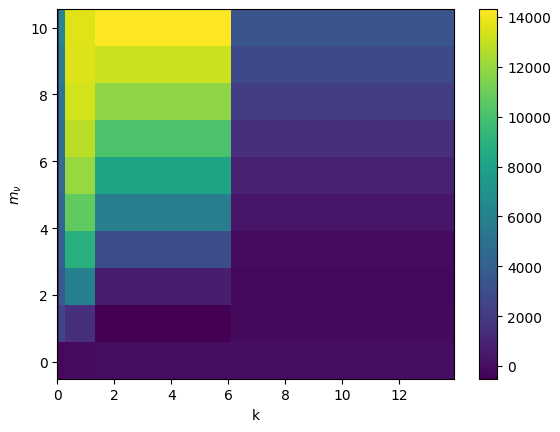

In [6]:
mv_max = 1e1
mv_min = 5e-2
step = 10
k_len = 10
mass_vec = np.linspace(mv_min,mv_max,step)
n = len(mass_vec)
kvec = list(np.logspace(-5,1,k_len))
print(kvec)
X = np.zeros([n,len(kvec)])
#kvec = list(np.logspace(-3,1,10))
t0 = time()
for mass_ind,mass in enumerate(mass_vec):
    
    res = error(mass,kvec)
    for k_ind,k in enumerate(kvec):
        print(mass,k)
        X[mass_ind,k_ind] = res[k_ind]
        
c = plt.pcolormesh(kvec,mass_vec,X)
print("time take = %s" %(time()-t0))
plt.colorbar(c)
#plt.xscale("log")
plt.ylabel(r"$m_{\nu}$")
plt.xlabel("k")


In [9]:
X


array([[ 8.20125717e+01,  8.17837804e+01,  8.19762190e+01,
         7.87795656e+01,  6.40664147e+01, -4.67919270e+01,
        -2.77853470e+02, -7.80551564e+01, -7.92839246e+00,
        -6.07423360e-01],
       [ 8.27945538e+01,  8.25341203e+01,  8.26768399e+01,
         8.17281417e+01,  8.99388493e+01,  5.27685632e+02,
         2.52310267e+03,  1.46597821e+03, -5.11446969e+02,
        -1.36177602e+02],
       [ 8.30520698e+01,  8.30942024e+01,  8.29923742e+01,
         8.26559466e+01,  1.00036268e+02,  6.04249767e+02,
         3.69585998e+03,  5.86820169e+03,  6.80871097e+02,
        -2.02717172e+02],
       [ 8.32634733e+01,  8.32067223e+01,  8.33094908e+01,
         8.34760994e+01,  1.09961906e+02,  6.78836136e+02,
         4.02085270e+03,  8.87350573e+03,  2.95652013e+03,
        -5.36302310e+01],
       [ 8.34176984e+01,  8.33537353e+01,  8.36249513e+01,
         8.42125548e+01,  1.19521967e+02,  7.68589585e+02,
         4.34553054e+03,  1.06933891e+04,  5.70340319e+03,
         3.

In [8]:
kvec = [1e-1,1,1e1]
H0 = 67
mv_test = 1
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
# 
cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3
            }
H0 /= (3*1e5) # i 1/Mpc
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()
pts = cosmo.get_perturbations()['scalar']
#print(bg.keys())

In [20]:
Omega_nu = cosmo.Omega_nu
cosmo.Omega_nu

0.02391656503221239

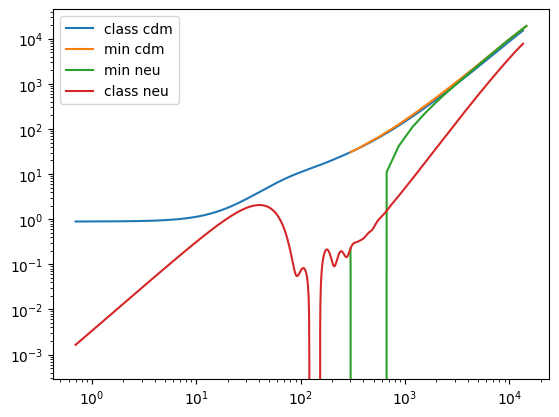

In [71]:
k_ind = 1
T_ini = 100
factor = 2.86
kvec = [1e-1,1,1e1]
H0 = 67


mv_test = 1

def func(mv_test,kvec,k_ind=0,factor=2.68,H0=67,T_ini=100 ):
    k = kvec[k_ind]
    Omega_M = 0.3
    Omega_R = 7e-5
    Omega_lambda = 1 - Omega_M - Omega_R
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                }
    H0 /= (3*1e5) # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    #print(bg.keys())

    z = bg["z"]
    a = 1/(z+1)
    aend = a[-1]
    a0 = a[0]
    mv = mv_test * 1e-6
    # cs front faktoren

    # udregner Hubbleparameteren

    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

    # udregnger tau 

    def tau_cal(a,y):
    # Vores "tids"-værdi i denne differentialligning er a
        tau = y[0]
        d_tau = 1 / (a ** 2 * H(a))
        return np.array(d_tau)

    # temperatur

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a,mv,factor):
        return factor * Tv(a) / mv

    # udregn a
    def a_solve(τ,y):
        a = y[0]
        a_dt = a * a * H(a)
        return [a_dt]

    tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0

    sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
    tau = sol_tau.y[0]

    sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
    a_tau = sol_a.t
    a = sol_a.y[0]

    a_interp = scipy.interpolate.interp1d(a_tau,a)

    # sammenlignings data fra Class


    def cdm_func(τ,y):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
        d_theta   =  - nabla2phi -  H(a) * theta * a
        return [d_delta,d_theta]

    #for k_ind,k in enumerate(kvec):
    delta_class = pts[k_ind]["delta_cdm"]
    theta_class = pts[k_ind]["theta_cdm"]
    tau_class = pts[k_ind]["tau [Mpc]"]
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
    a_class = pts[k_ind]["a"]
    delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
    theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)
    delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
    theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)
    
    # T-span1
    
    t_span = [T_ini,tau[-1]]
    
    y01 = [delta_init,theta_init]
    
    sol_cdm = sc.solve_ivp(cdm_func, t_span = t_span, y0 = y01)
    
    t_cdm = sol_cdm.t
    
    delta_cdm = sol_cdm.y[0]
    
    delta_cdm_interp = scipy.interpolate.interp1d(t_cdm,delta_cdm)


    def neu_func1(t,y,k,mv,factor):
        delta = y[0]
        theta = y[1]    
        a = a_interp(t)
        d_delta   = - theta
        delta_cdm = delta_cdm_interp(t)
        d_theta   =  -  H(a) * a * theta - (3/2) * H0 * H0 * Omega_M * delta_cdm / a  + k ** 2 * cs(a,mv,factor) ** 2 * delta
        return [d_delta,d_theta]


    y01_neutrino = [delta_neutrino_init,theta_neutrino_init]
    #factor = 2.68
    sol_neu = sc.solve_ivp(neu_func1, t_span = t_span, y0 = y01_neutrino,args = (k, mv, factor))
    
    
    plt.loglog(tau_class,-delta_class,label="class cdm")
    plt.loglog(t_cdm,-delta_cdm,label="min cdm")
    plt.loglog(sol_neu.t,-sol_neu.y[0],label="min neu ")
    plt.loglog(tau_class,-delta_neutrino_class,label="class neu")
    plt.legend()

    
func(5e-1,kvec=[1e-1,1e-6,1e1],k_ind=1,T_ini=3e2)